In [1]:
import numpy as np
import pandas as pd
from matplotlib.pyplot import subplots
from statsmodels.api import OLS
import sklearn.model_selection as skm
import sklearn.linear_model as skl
from sklearn.preprocessing import StandardScaler
from ISLP import load_data
from ISLP.models import ModelSpec as MS
from functools import partial
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import PLSRegression
from ISLP.models import \
(Stepwise,
sklearn_selected,
sklearn_selection_path)
from l0bnb import fit_path
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Question 8 Simulated Data, forward, backward stepwise selection

In [2]:
np.random.seed(10)

In [3]:
n=100
X = np.random.normal(size=n)
eps = np.random.normal(size=n)

In [4]:
B_0 = 5.2
B_1 = 7.8
B_2 = 3.1
B_3 = 1.4

In [5]:
Y = B_0 + B_1*X + B_2*np.power(X, 2) + B_3*np.power(X, 3) + eps

In [6]:
def nCp(sigma2, estimator, X, Y):
    """
    Negative Cp Statistic
    Negative because sklearn maximises a score, 
    so we make it negative to effectively minimize Cp.
    """
    n, p = X.shape
    Yhat = estimator.predict(X)
    RSS = np.sum((Y - Yhat) ** 2)
    return -(RSS + 2 * p * sigma2) / n

In [7]:
Xs = pd.DataFrame({'X': X, 
                   'X2': X**2, 
                   'X3': X**3, 
                   'X4': X**4, 
                   'X5': X**5, 
                   'X6': X**6, 
                   'X7': X**7, 
                   'X8': X**8, 
                   'X9': X**9, 
                   'X10': X**10
})
Yd = pd.DataFrame({'Y': Y})

In [8]:
# Estimate variance based on the biggest model's MSE
design = MS(Xs).fit(Xs)
X = design.transform(Xs)
sigma2 = OLS(Y, X).fit().scale

In [9]:
eps.var() # close to 1

0.9708848261009662

In [10]:
sigma2 # as expected close to 1 because we expect the variance to be almost the same as the epsilon variance

1.0199918396319778

In [11]:
neg_Cp = partial(nCp, sigma2)

In [12]:
strategy = Stepwise.first_peak(
    design,
    direction='forward',
    max_terms=len(design.terms))

In [13]:
Y_Cp = sklearn_selected(OLS,
                       strategy,
                       scoring=neg_Cp)
Y_Cp.fit(Xs, Y)
Y_Cp.selected_state_

('X', 'X2', 'X3')

In [14]:
Y_Cp.results_.params

intercept    5.290742
X            7.846836
X2           3.071086
X3           1.408303
dtype: float64

### Backwards stepwise selection

In [15]:
strategy_backward = Stepwise.first_peak(design,
                                        direction='backwards',
                                        max_terms=len(design.terms))

Y_Cp = sklearn_selected(OLS,
                       strategy_backward,
                       scoring=neg_Cp)
Y_Cp.fit(Xs, Y)
Y_Cp.selected_state_

('X', 'X2', 'X3')

In [16]:
Y_Cp.results_.params # same results

intercept    5.290742
X            7.846836
X2           3.071086
X3           1.408303
dtype: float64

In [17]:
K=5
D = design.fit_transform(Xs)
kfold = skm.KFold(K,
                  random_state=0,
                  shuffle=True)
scaler = StandardScaler(with_mean=True,  with_std=True)
lassoCV = skl.ElasticNetCV(n_alphas=100, 
                           l1_ratio=1,
                           cv=kfold)
pipeCV = Pipeline(steps=[('scaler', scaler),('lasso', lassoCV)])
pipeCV.fit(D, Y)
tuned_lasso = pipeCV.named_steps['lasso']
tuned_lasso.alpha_

0.04013594567515574

In [18]:
lambdas, soln_array = skl.Lasso.path(D, 
                                    Y,
                                    l1_ratio=1,
                                    n_alphas=100)[:2]
soln_path = pd.DataFrame(soln_array.T,
                         columns=D.columns,
                         index=-np.log(lambdas))

/Users/laineridgway/miniforge3/envs/islp/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:614: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.749540938330028, tolerance: 2.613503427885197
  model = cd_fast.enet_coordinate_descent_gram(
/Users/laineridgway/miniforge3/envs/islp/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:614: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10.323323712160345, tolerance: 2.613503427885197
  model = cd_fast.enet_coordinate_descent_gram(


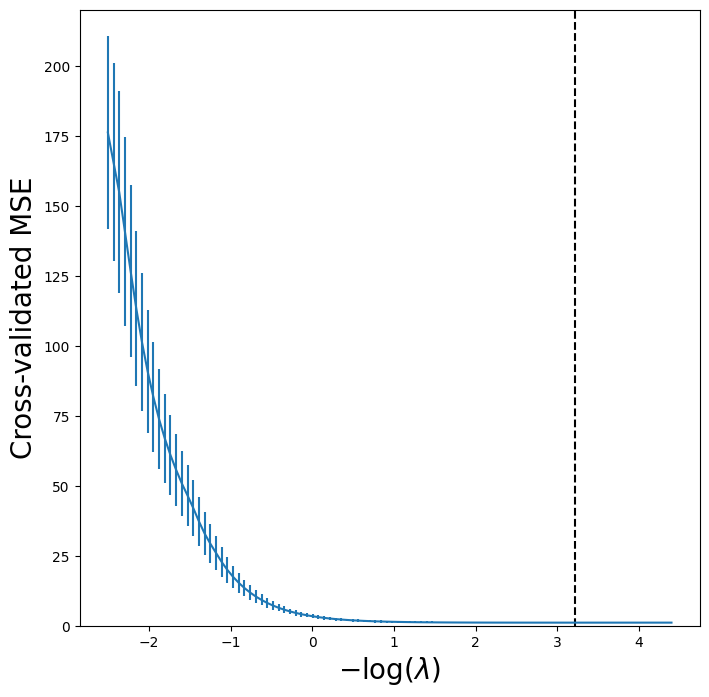

In [19]:
lassoCV_fig, ax = subplots(figsize=(8,8))
ax.errorbar(-np.log(tuned_lasso.alphas_),
            tuned_lasso.mse_path_.mean(1),
            yerr=tuned_lasso.mse_path_.std(1) / np.sqrt(K))
ax.axvline(-np.log(tuned_lasso.alpha_), c='k', ls='--')
ax.set_ylim([0,220])
ax.set_xlabel('$-\log(\lambda)$', fontsize=20)
ax.set_ylabel('Cross-validated MSE', fontsize=20);

In [20]:
tuned_lasso.coef_

array([0.        , 7.63180373, 4.07146695, 4.59900213, 0.        ,
       0.        , 0.        , 0.        , 0.11135223, 0.        ,
       0.0669003 ])

The best model used X, X2, X3, X8, X10

### f) Do the same but with new Y

In [21]:
np.random.seed(10)
n=100
X = np.random.normal(size=n)
eps = np.random.normal(size=n)

In [22]:
B_0 = 1.3
B_7 = 2.8

In [23]:
Y = B_0 + B_7*np.power(X, 7) + eps

#### Forward Stepwise

In [24]:
# Estimate variance based on the biggest model's MSE
design = MS(Xs).fit(Xs)
X = design.transform(Xs)
sigma2 = OLS(Y, X).fit().scale

In [25]:
neg_Cp = partial(nCp, sigma2)

In [26]:
strategy = Stepwise.first_peak(
    design,
    direction='forward',
    max_terms=len(design.terms))

In [27]:
Y_Cp = sklearn_selected(OLS,
                       strategy,
                       scoring=neg_Cp)
Y_Cp.fit(Xs, Y)
Y_Cp.selected_state_

('X7',)

#### Lasso

In [28]:
lassoCV = skl.ElasticNetCV(n_alphas=100, 
                           l1_ratio=1,
                           cv=kfold)
pipeCV = Pipeline(steps=[('scaler', scaler),('lasso', lassoCV)])
pipeCV.fit(D, Y)
tuned_lasso = pipeCV.named_steps['lasso']
tuned_lasso.alpha_

0.25160553826280685

In [29]:
tuned_lasso.coef_

array([  0.        ,  -0.76328899,  -0.        ,   0.        ,
        -0.        ,  41.44354856,  -0.        , 154.80471938,
        -0.        ,  56.56056015,   0.        ])

Best model was X1, X5, X7, X9 (incorrect)

# Question 9 College Continued

In [30]:
College = load_data('College')

In [31]:
College['Private'] = College['Private'].apply(lambda x: 1 if x.lower() == "yes" else 0)

In [32]:
College_train, College_test = train_test_split(College,
                                          test_size=0.25,
                                          random_state=0)

### Linear Regression

In [33]:
design = MS(College.columns.drop('Apps')).fit(College)
X_train = design.transform(College_train)
Y_train = College_train['Apps']
model = OLS(Y_train, X_train).fit()

In [34]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   Apps   R-squared:                       0.934
Model:                            OLS   Adj. R-squared:                  0.932
Method:                 Least Squares   F-statistic:                     470.2
Date:                Sun, 21 Jan 2024   Prob (F-statistic):          9.81e-320
Time:                        21:09:43   Log-Likelihood:                -4870.7
No. Observations:                 582   AIC:                             9777.
Df Residuals:                     564   BIC:                             9856.
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
intercept      30.3255    474.639      0.064      0.949    -901.950     962.601
Private      -563.4690    160.220     -3.517      0.000    -878.169    -248.769
Accept          1.6241      0.045     35.859      0.000       1.535       1.713
Enroll         -1.0359      0.213     -4.874      0.000      -1.453      -0.618
Top10perc      57.2126      6.525      8.768      0.000      44.396      70.029
Top25perc     -17.3420      5.209     -3.329      0.001     -27.574      -7.110
F.Undergrad     0.0724      0.038      1.927      0.055      -0.001       0.146
P.Undergrad     0.0534      0.035      1.520      0.129      -0.016       0.122
Outstate       -0.0761      0.022     -3.402      0.001      -0.120      -0.032
Room.Board      0.1772      0.057      3.090      0.002       0.065       0.290
Books           0.0145      0.265      0.055      0.956      -0.506       0.535
Personal       -0.0115      0.073     -0.159      0.874      -0.154       0.131
PhD           -11.1582      5.454     -2.046      0.041     -21.871      -0.445
Terminal       -3.0762      5.921     -0.520      0.604     -14.705       8.553
S.F.Ratio       3.7479     14.698      0.255      0.799     -25.121      32.617
perc.alumni     0.6742      4.937      0.137      0.891      -9.022      10.371
Expend          0.0474      0.014      3.374      0.001       0.020       0.075
Grad.Rate       8.3737      3.526      2.375      0.018       1.447      15.300
==============================================================================
Omnibus:                      346.664   Durbin-Watson:                   2.151
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             6272.124
Skew:                           2.256   Prob(JB):                         0.00
Kurtosis:                      18.437   Cond. No.                     1.81e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.81e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [35]:
Y_test = College_test['Apps']
X_test = design.transform(College_test)
Y_hat = model.predict(X_test)
MSE = np.mean((Y_hat - Y_test)**2)

In [36]:
MSE # test error

1022430.0889254622

### Ridge Regression

In [37]:
X = College[College.columns.drop('Apps')]
Y = College['Apps']

In [38]:
K = 5
kfold = skm.KFold(K,
                  random_state=0,
                  shuffle=True)

scaler = StandardScaler(with_mean=True,  with_std=True)

In [39]:
lambdas = 10**np.linspace(8, -2, 100) / Y.std()

ridgeCV = skl.ElasticNetCV(alphas=lambdas, 
                           l1_ratio=0,
                           cv=kfold)
pipeCV = Pipeline(steps=[('scaler', scaler),
                         ('ridge', ridgeCV)])
pipeCV.fit(X_train, Y_train)

/Users/laineridgway/miniforge3/envs/islp/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:614: UserWarning: Coordinate descent without L1 regularization may lead to unexpected results and is discouraged. Set l1_ratio > 0 to add L1 regularization.
  model = cd_fast.enet_coordinate_descent_gram(
/Users/laineridgway/miniforge3/envs/islp/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:614: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3996587930.7662086, tolerance: 799419.2332946239
  model = cd_fast.enet_coordinate_descent_gram(
/Users/laineridgway/miniforge3/envs/islp/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:614: UserWarning: Coordinate descent without L1 regularization may lead to unexpected results and is discouraged. Set l1_ratio > 0 to add L1 regularization.
  model = cd_fast.enet_coordinate_descent_gram(
/Users/laineridgway/miniforge3/e

Pipeline(steps=[('scaler', StandardScaler()),
                ('ridge',
                 ElasticNetCV(alphas=array([2.58384481e+04, 2.04765282e+04, 1.62272984e+04, 1.28598565e+04,
       1.01912163e+04, 8.07636466e+03, 6.40038087e+03, 5.07219239e+03,
       4.01962572e+03, 3.18548464e+03, 2.52444210e+03, 2.00057719e+03,
       1.58542321e+03, 1.25642078e+03, 9.95691984e+02, 7.89068869e+02,
       6.25323584e+02, 4.95558247e+02,...
       2.14515335e-04, 1.69999734e-04, 1.34721882e-04, 1.06764788e-04,
       8.46092684e-05, 6.70513983e-05, 5.31370864e-05, 4.21102323e-05,
       3.33716389e-05, 2.64464531e-05, 2.09583618e-05, 1.66091433e-05,
       1.31624620e-05, 1.04310261e-05, 8.26640977e-06, 6.55098838e-06,
       5.19154626e-06, 4.11421162e-06, 3.26044235e-06, 2.58384481e-06]),
                              cv=KFold(n_splits=5, random_state=0, shuffle=True),
                              l1_ratio=0))])

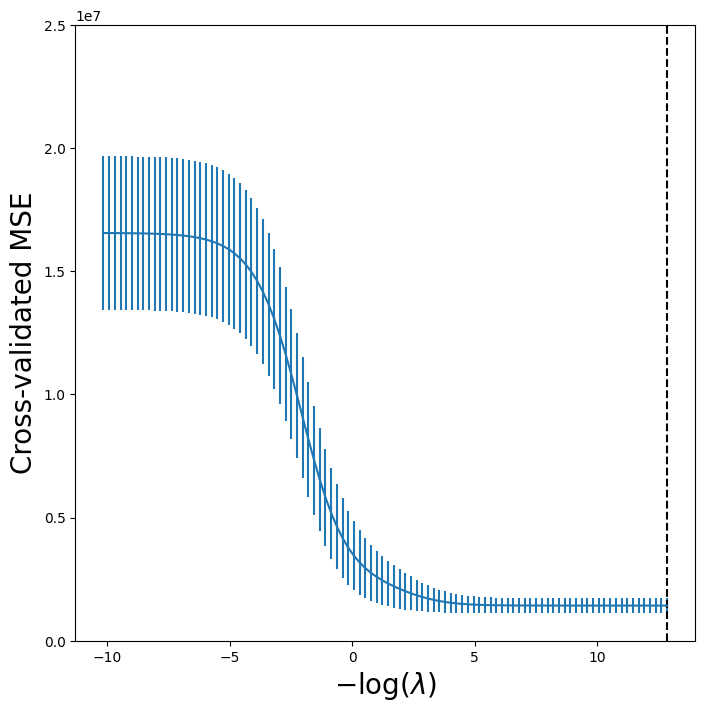

In [40]:
tuned_ridge = pipeCV.named_steps['ridge']
ridgeCV_fig, ax = subplots(figsize=(8,8))
ax.errorbar(-np.log(lambdas),
            tuned_ridge.mse_path_.mean(1),
            yerr=tuned_ridge.mse_path_.std(1) / np.sqrt(K))
ax.axvline(-np.log(tuned_ridge.alpha_), c='k', ls='--')
ax.set_ylim([0,25000000])
ax.set_xlabel('$-\log(\lambda)$', fontsize=20)
ax.set_ylabel('Cross-validated MSE', fontsize=20);

In [41]:
tuned_ridge.mse_path_.shape

(100, 5)

In [42]:
np.min(tuned_ridge.mse_path_.mean(1)) # row mean per choice of lambda

1425988.0216411792

In [43]:
# best value for lambda
alpha_ = tuned_ridge.alpha_

ridge = skl.ElasticNet(alpha=alpha_, 
                           l1_ratio=0)
pipe = Pipeline(steps=[('scaler', scaler),
                         ('ridge', ridge)])
pipe.fit(X_train, Y_train)

/Users/laineridgway/miniforge3/envs/islp/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.167e+08, tolerance: 9.610e+05 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


Pipeline(steps=[('scaler', StandardScaler()),
                ('ridge',
                 ElasticNet(alpha=2.5838448050358095e-06, l1_ratio=0))])

In [44]:
Yhat = pipe.predict(X_test)
np.mean((Yhat - Y_test)**2) # test MSE

1022416.2285469921

### Lasso Regression

In [45]:
lassoCV = skl.ElasticNetCV(n_alphas=100, 
                           l1_ratio=1,
                           cv=kfold)
pipeCV = Pipeline(steps=[('scaler', scaler),
                         ('lasso', lassoCV)])
pipeCV.fit(X_train, Y_train)
tuned_lasso = pipeCV.named_steps['lasso']
tuned_lasso.alpha_

27.19057396544297

In [46]:
lambdas, soln_array = skl.Lasso.path(X_train, 
                                    Y_train,
                                    l1_ratio=1,
                                    n_alphas=100)[:2]
soln_path = pd.DataFrame(soln_array.T,
                         columns=X_train.columns,
                         index=-np.log(lambdas))

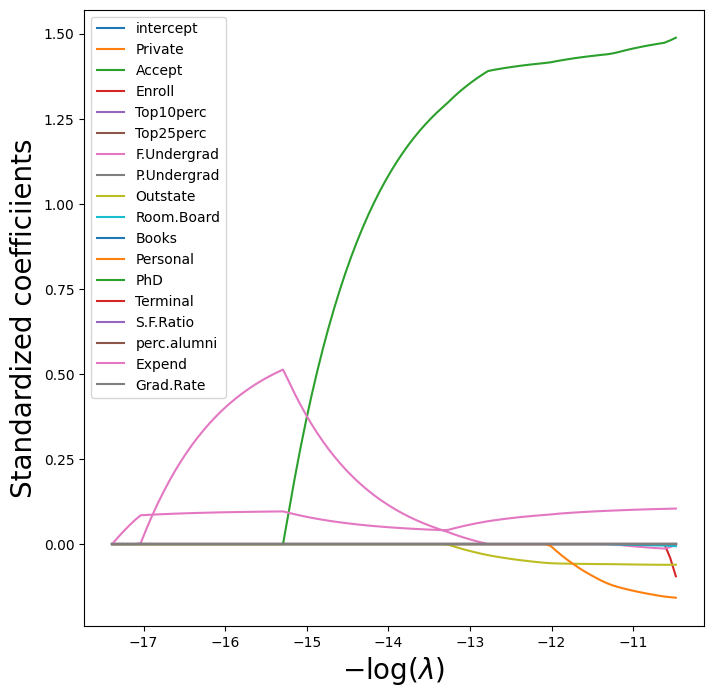

In [47]:
path_fig, ax = subplots(figsize=(8,8))
soln_path.plot(ax=ax, legend=False)
ax.legend(loc='upper left')
ax.set_xlabel('$-\log(\lambda)$', fontsize=20)
ax.set_ylabel('Standardized coefficiients', fontsize=20);

In [48]:
tuned_lasso.alpha_

27.19057396544297

In [49]:
np.min(tuned_lasso.mse_path_.mean(1))

1428104.8474233106

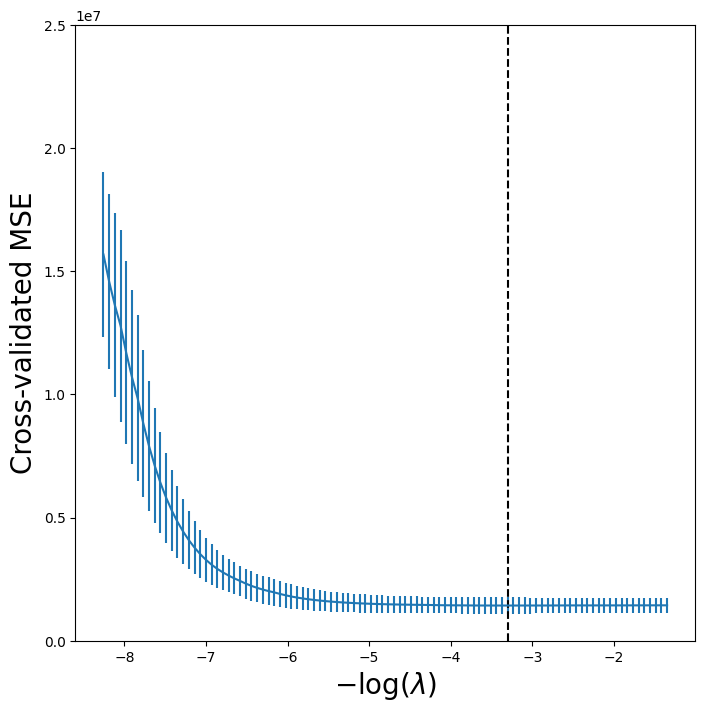

In [50]:
lassoCV_fig, ax = subplots(figsize=(8,8))
ax.errorbar(-np.log(tuned_lasso.alphas_),
            tuned_lasso.mse_path_.mean(1),
            yerr=tuned_lasso.mse_path_.std(1) / np.sqrt(K))
ax.axvline(-np.log(tuned_lasso.alpha_), c='k', ls='--')
ax.set_ylim([0,25000000])
ax.set_xlabel('$-\log(\lambda)$', fontsize=20)
ax.set_ylabel('Cross-validated MSE', fontsize=20);

In [51]:
# best value for lambda
alpha_ = tuned_lasso.alpha_

lasso = skl.ElasticNet(alpha=alpha_, 
                           l1_ratio=1)
pipe = Pipeline(steps=[('scaler', scaler),
                         ('lasso', lasso)])
pipe.fit(X_train, Y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('lasso', ElasticNet(alpha=27.19057396544297, l1_ratio=1))])

In [52]:
Yhat = pipe.predict(X_test)
np.mean((Yhat - Y_test)**2) # test MSE

1016583.3530579971

### PCR

In [53]:
X_train = X_train.drop(['intercept'] ,axis=1)
X_test = X_test.drop(['intercept'] ,axis=1)

In [54]:
pca = PCA(n_components=2)
linreg = skl.LinearRegression() # adds intercept automatically
pipe = Pipeline([('scaler', scaler), 
                 ('pca', pca),
                 ('linreg', linreg)])

In [55]:
param_grid = {'pca__n_components': range(1, X.shape[1])}
grid = skm.GridSearchCV(pipe,
                        param_grid,
                        cv=kfold,
                        scoring='neg_mean_squared_error')
grid.fit(X_train, Y_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=0, shuffle=True),
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('pca', PCA(n_components=2)),
                                       ('linreg', LinearRegression())]),
             param_grid={'pca__n_components': range(1, 17)},
             scoring='neg_mean_squared_error')

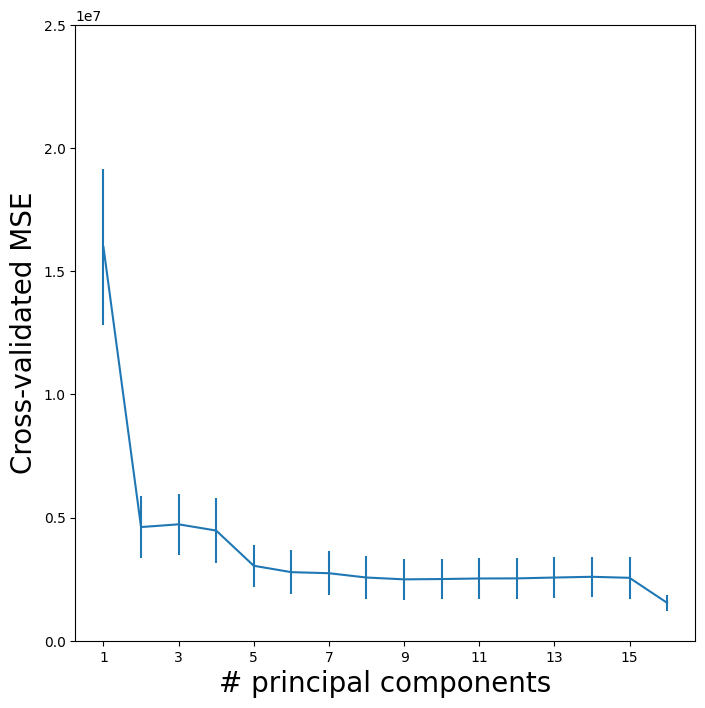

In [56]:
pcr_fig, ax = subplots(figsize=(8,8))
n_comp = param_grid['pca__n_components']
ax.errorbar(n_comp,
            -grid.cv_results_['mean_test_score'],
            grid.cv_results_['std_test_score'] / np.sqrt(K))
ax.set_ylabel('Cross-validated MSE', fontsize=20)
ax.set_xlabel('# principal components', fontsize=20)
ax.set_xticks(n_comp[::2])
ax.set_ylim([0,25000000]);

In [57]:
best_pca_n = grid.best_params_['pca__n_components']

In [58]:
pca = PCA(n_components=best_pca_n)
linreg = skl.LinearRegression() # adds intercept automatically
pipe = Pipeline([('scaler', scaler), 
                 ('pca', pca),
                 ('linreg', linreg)])

In [59]:
pipe.fit(X_train, Y_train)
pipe.named_steps['linreg'].coef_

array([ 384.41596737, 1610.37407754, -174.73373112,  582.86012121,
       1245.63502865, -335.64403864, -390.42036453, -371.47592549,
       -392.95424603,  193.05636542,  136.11556742,    4.19431906,
       -125.97688297, -176.81414375, 2402.96762785, 2477.93764111])

In [60]:
Yhat = pipe.predict(X_test)
np.mean((Yhat - Y_test)**2) # test error

1025469.2195196968

In [61]:
grid.best_params_ # M chosen by CV

{'pca__n_components': 16}

### PLS

In [62]:
pls = PLSRegression(n_components=2, 
                    scale=True)
param_grid = {'n_components':range(1, X_train.shape[1] + 1)}
grid = skm.GridSearchCV(pls,
                        param_grid,
                        cv=kfold,
                        scoring='neg_mean_squared_error')
grid.fit(X_train, Y_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=0, shuffle=True),
             estimator=PLSRegression(),
             param_grid={'n_components': range(1, 18)},
             scoring='neg_mean_squared_error')

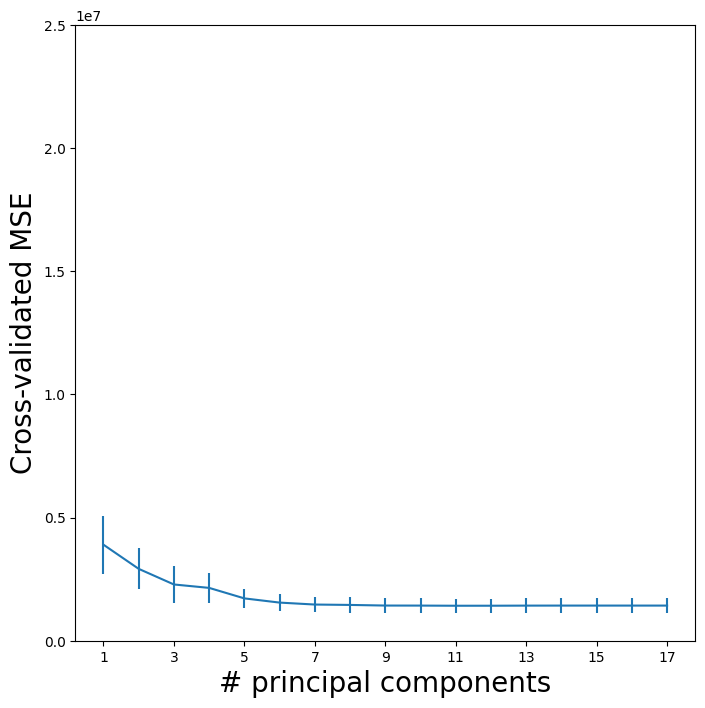

In [63]:
pls_fig, ax = subplots(figsize=(8,8))
n_comp = param_grid['n_components']
ax.errorbar(n_comp,
            -grid.cv_results_['mean_test_score'],
            grid.cv_results_['std_test_score'] / np.sqrt(K))
ax.set_ylabel('Cross-validated MSE', fontsize=20)
ax.set_xlabel('# principal components', fontsize=20)
ax.set_xticks(n_comp[::2])
ax.set_ylim([0,25000000]);

In [64]:
grid.best_params_

{'n_components': 11}

In [65]:
pls = PLSRegression(n_components=11, 
                    scale=True)
pls.fit(X_train, Y_train)

PLSRegression(n_components=11)

In [66]:
Yhat = pls.predict(X_test)
np.mean((Yhat - Y_test)**2) # test error

1028278.2408135456

### g) Comments
Lasso got the best results.

# Question 10

In [67]:
n = 1000
p = 20
np.random.seed(42)
X = np.random.randn(n, p)
beta = np.random.randn(p)
zero_indices = np.random.choice(range(p), size=int(p * 0.4), replace=False)  # 30% zeros
beta[zero_indices] = 0
epsilon = np.random.randn(n) * 1.4

Y = X @ beta + epsilon # matrix multiplication

In [68]:
df = pd.DataFrame(X, columns=[f'X_{i+1}' for i in range(p)])
Y_series = pd.Series(Y, name='Y')
df['Y'] = Y

In [69]:
train, test = train_test_split(df,
                               test_size=900,
                               random_state=0)

### Best Subset Selection

In [70]:
X_train = train.drop(['Y'], axis=1)
X_test = test.drop(['Y'], axis=1)
Y_train = train['Y']
Y_test = test['Y']

In [71]:
path = fit_path(np.asarray(X_train), 
                np.asarray(Y_train),
                max_nonzeros=X_train.shape[1], 
                intercept=False)

Preprocessing Data.
BnB Started.
Iteration: 1. Number of non-zeros:  1
Iteration: 2. Number of non-zeros:  1
Iteration: 3. Number of non-zeros:  2
Iteration: 4. Number of non-zeros:  2
Iteration: 5. Number of non-zeros:  2
Iteration: 6. Number of non-zeros:  3
Iteration: 7. Number of non-zeros:  3
Iteration: 8. Number of non-zeros:  5
Iteration: 9. Number of non-zeros:  5
Iteration: 10. Number of non-zeros:  5
Iteration: 11. Number of non-zeros:  7
Iteration: 12. Number of non-zeros:  7
Iteration: 13. Number of non-zeros:  7
Iteration: 14. Number of non-zeros:  7
Iteration: 15. Number of non-zeros:  8
Iteration: 16. Number of non-zeros:  8
Iteration: 17. Number of non-zeros:  8
Iteration: 18. Number of non-zeros:  10
Iteration: 19. Number of non-zeros:  10
Iteration: 20. Number of non-zeros:  10
Iteration: 21. Number of non-zeros:  10
Iteration: 22. Number of non-zeros:  10
Iteration: 23. Number of non-zeros:  10
Iteration: 24. Number of non-zeros:  12
Iteration: 25. Number of non-zero

In [72]:
path[3] # to see structure

{'B': array([ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  2.04024907,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        , -1.20072106,  0.        ]),
 'B0': 0.0,
 'lambda_0': 0.04375770172468456,
 'M': 0.6840982103893744,
 'Time_exceeded': False}

In [73]:
path[3]['B']

array([ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  2.04024907,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        , -1.20072106,  0.        ])

In [74]:
mse_list = []
# Count num non-zeros for model sizes
model_sizes = [np.count_nonzero(model['B']) for model in path]

for model in path:
    coefficients = model['B']
    Y_pred = np.dot(np.asarray(X_train), coefficients) # predictions

    mse = np.mean((np.asarray(Y_train) - Y_pred) ** 2)
    mse_list.append(mse)

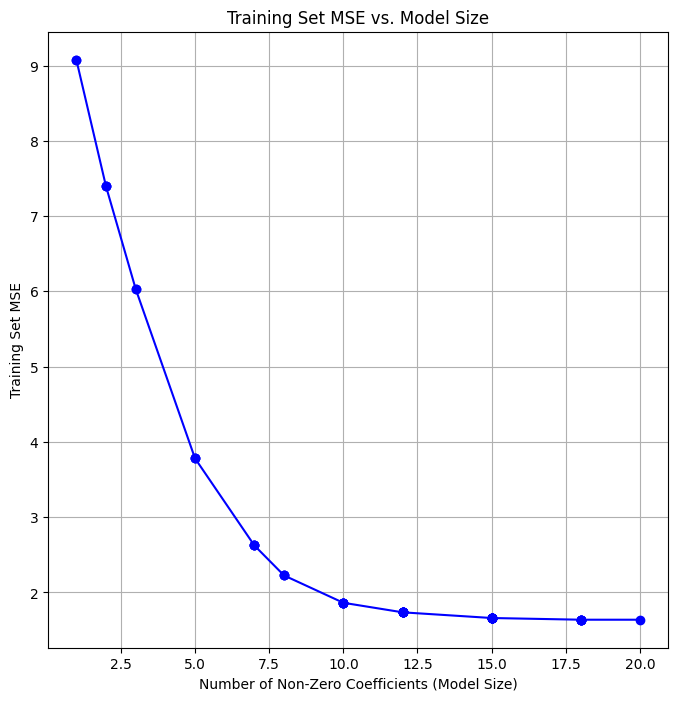

In [75]:
# Plotting
path_fig, ax = subplots(figsize=(8,8))
ax.plot(model_sizes, mse_list, marker='o', linestyle='-', color='blue')
ax.set_xlabel('Number of Non-Zero Coefficients (Model Size)')
ax.set_ylabel('Training Set MSE')
ax.set_title('Training Set MSE vs. Model Size')
ax.grid(True);

#### Test MSE

In [76]:
mse_test = []
for model in path:
    coefficients = model['B']
    Y_pred = np.dot(np.asarray(X_test), coefficients) # predictions

    mse = np.mean((np.asarray(Y_test) - Y_pred) ** 2)
    mse_test.append(mse)

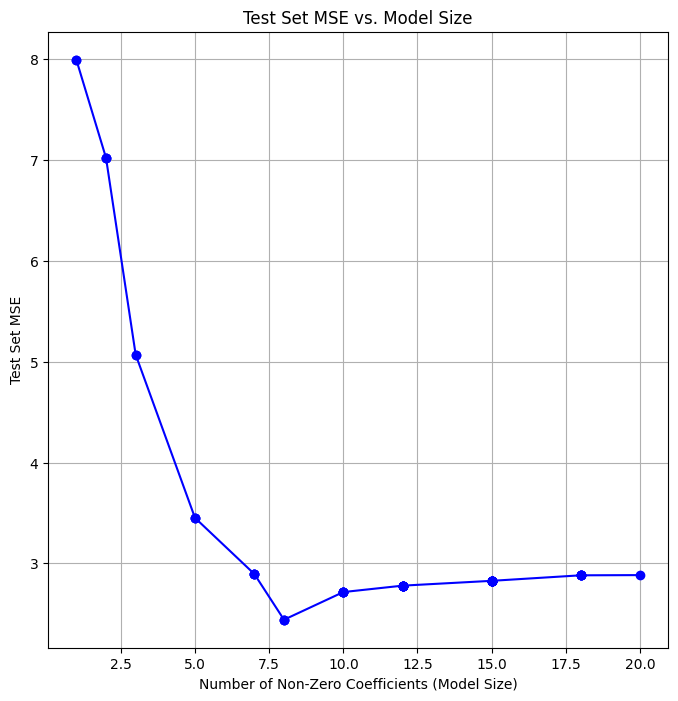

In [77]:
# Plotting
path_fig, ax = subplots(figsize=(8,8))
ax.plot(model_sizes, mse_test, marker='o', linestyle='-', color='blue')
ax.set_xlabel('Number of Non-Zero Coefficients (Model Size)')
ax.set_ylabel('Test Set MSE')
ax.set_title('Test Set MSE vs. Model Size')
ax.grid(True);

### e) Best Model (Size = 8)

In [78]:
path[14]['B'] # best model

array([ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
       -0.65387282,  0.        ,  0.        ,  0.        ,  2.02570635,
        0.98555432,  0.74377741,  0.        , -1.15424797,  0.60440909,
        0.        , -1.1300971 ,  0.        , -1.13808645,  0.        ])

In [79]:
beta

array([ 0.34828625,  0.28332359,  0.        ,  0.        ,  0.        ,
       -0.65418433,  0.        ,  0.        , -0.23154949,  2.16688403,
        0.80294993,  0.44809821,  0.        , -1.04635004,  0.52297157,
       -0.07151401, -1.33927032,  0.        , -0.95870373,  0.        ])

The estimated coefficients contain more 0's than in the true model. Of the non-zero estimated coefficients, they are very similar.

### g) Plot

In [80]:
r_values = [1, 2, 3, 5, 7, 8, 10, 12, 15, 17, 18, 20]

In [81]:
best_model_per_size = [1, 4, 6, 9, 13, 16, 22, 32, 44, 45, 57, 58]
best_paths = [path[i] for i in best_model_per_size]
best_model_coefficients = [best_path['B'] for best_path in best_paths]

In [82]:
mse_list = []
for B in best_model_coefficients:
    coef_mse = np.sqrt(np.sum((beta - B)**2))
    mse_list.append(coef_mse)

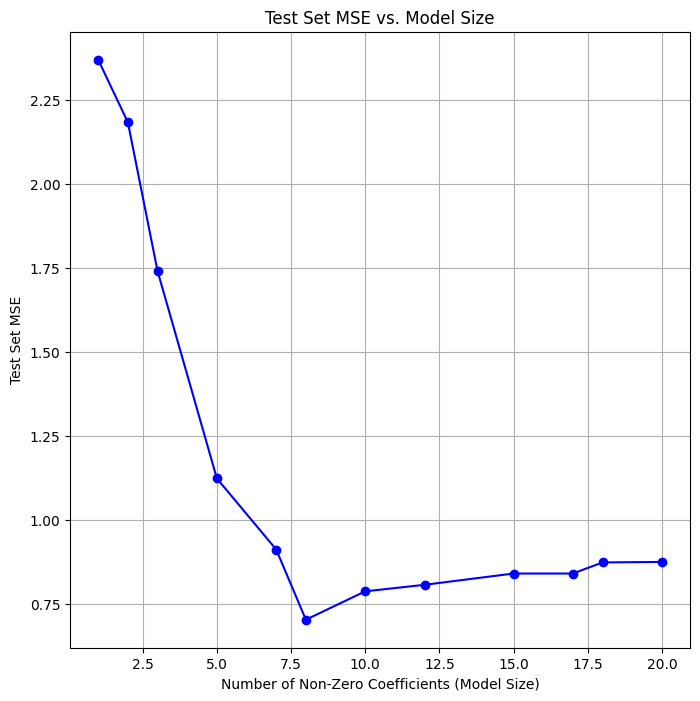

In [83]:
# Plot
path_fig, ax = subplots(figsize=(8,8))
ax.plot(r_values, mse_list, marker='o', linestyle='-', color='blue')
ax.set_xlabel('Number of Non-Zero Coefficients (Model Size)')
ax.set_ylabel('Test Set MSE')
ax.set_title('Test Set MSE vs. Model Size')
ax.grid(True);

Follows very similar curve to the MSE plot, not surprisingly (the better the coefficients are estimated, the better the model).

# Question 11

In [84]:
Boston = load_data('Boston')

In [85]:
X = Boston.drop(['crim'], axis=1)
Y = Boston['crim']

# Splitting the data into train and test sets directly.
X_train, X_test, Y_train, Y_test = train_test_split(X, Y,
                                                    test_size=0.25,
                                                    random_state=0)

In [86]:
CV_errors = {}

### Best Subset Selection

In [87]:
path = fit_path(np.asarray(X_train), 
                np.asarray(Y_train),
                max_nonzeros=X_train.shape[1],
                intercept=False)

Preprocessing Data.
BnB Started.
Iteration: 1. Number of non-zeros:  1
Iteration: 2. Number of non-zeros:  2
Iteration: 3. Number of non-zeros:  6
Iteration: 4. Number of non-zeros:  9
Iteration: 5. Number of non-zeros:  11
Iteration: 6. Number of non-zeros:  12


In [88]:
mse_means = []
coefficients = [model['B'] for model in path]
for coef in coefficients:
    mse_list = []
    for train_index, test_index in kfold.split(X): # CV 
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        Y_train, Y_test = Y.iloc[train_index], Y.iloc[test_index]
        
        # mse
        Y_pred = np.dot(np.asarray(X_test), coef) # predictions
        mse = np.mean((Y_test - Y_pred)**2)
        mse_list.append(mse)
        
    mse_means.append(np.mean(mse_list))

mse_means

[47.42862498939958,
 43.60065005871694,
 41.8058290491958,
 41.481162052622985,
 41.50243665680049,
 41.489999196610384]

Best model is with 9 non-zero coefficients

In [89]:
coef = path[3]['B']
Yhat = np.dot(np.asarray(X_test), coef)
np.mean((Y_test - Yhat)**2) # test error

20.33823651144542

In [90]:
CV_errors['Best Subset'] = np.min(mse_means)

### Lasso

In [91]:
X = Boston.drop(['crim'], axis=1)
Y = Boston['crim']

# Splitting the data into train and test sets directly.
X_train, X_test, Y_train, Y_test = train_test_split(X, Y,
                                                    test_size=0.25,
                                                    random_state=0)

In [92]:
lassoCV = skl.ElasticNetCV(n_alphas=100, 
                           l1_ratio=1,
                           cv=kfold)
pipeCV = Pipeline(steps=[('scaler', scaler),
                         ('lasso', lassoCV)])
pipeCV.fit(X_train, Y_train)
tuned_lasso = pipeCV.named_steps['lasso']
best_alpha = tuned_lasso.alpha_
best_alpha

0.10254279593477782

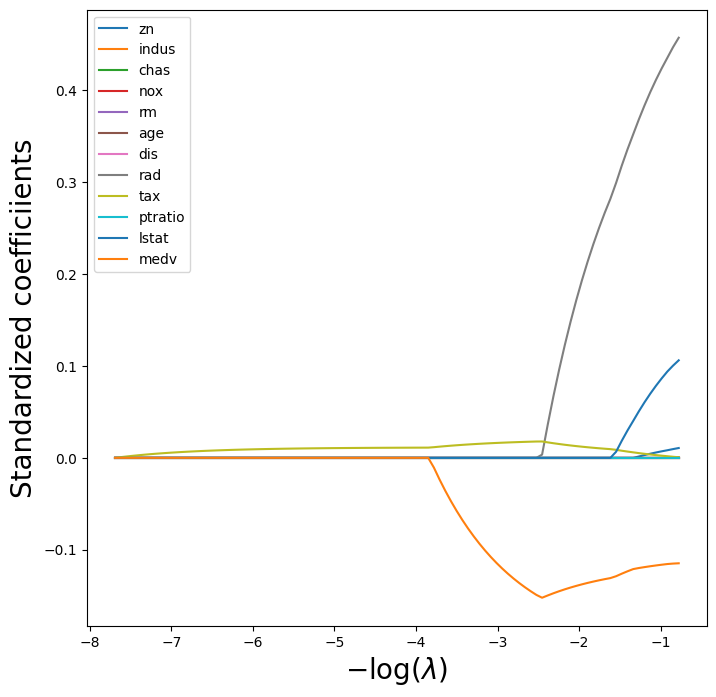

In [93]:
lambdas, soln_array = skl.Lasso.path(X_train, 
                                    Y_train,
                                    l1_ratio=1,
                                    n_alphas=100)[:2]
soln_path = pd.DataFrame(soln_array.T,
                         columns=X_train.columns,
                         index=-np.log(lambdas))

path_fig, ax = subplots(figsize=(8,8))
soln_path.plot(ax=ax, legend=False)
ax.legend(loc='upper left')
ax.set_xlabel('$-\log(\lambda)$', fontsize=20)
ax.set_ylabel('Standardized coefficiients', fontsize=20);

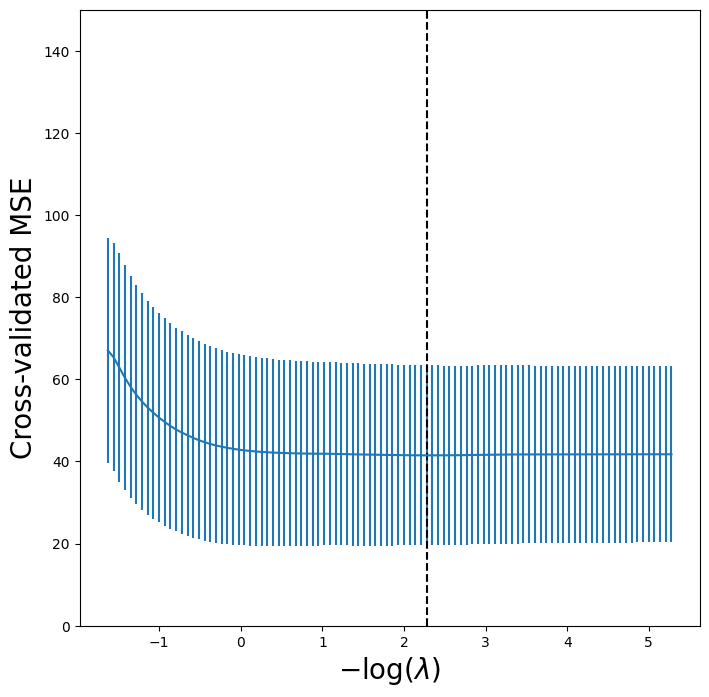

In [94]:
lassoCV_fig, ax = subplots(figsize=(8,8))
ax.errorbar(-np.log(tuned_lasso.alphas_),
            tuned_lasso.mse_path_.mean(1),
            yerr=tuned_lasso.mse_path_.std(1) / np.sqrt(K))
ax.axvline(-np.log(tuned_lasso.alpha_), c='k', ls='--')
ax.set_ylim([0,150])
ax.set_xlabel('$-\log(\lambda)$', fontsize=20)
ax.set_ylabel('Cross-validated MSE', fontsize=20);

In [95]:
np.min(tuned_lasso.mse_path_.mean(1))

41.488203881238015

In [96]:
CV_errors['Lasso'] = np.min(tuned_lasso.mse_path_.mean(1))

### Ridge

In [97]:
lambdas = 10**np.linspace(8, -2, 100) / Y.std()

ridge = skl.ElasticNet(alpha=lambdas[59], # arbitrary
                       l1_ratio=0)
pipe = Pipeline(steps=[('scaler', scaler), 
                       ('ridge', ridge)])
# pipe.fit(X_train, Y_train)

In [98]:
param_grid = {'ridge__alpha': lambdas}
grid = skm.GridSearchCV(pipe, 
                        param_grid,
                        cv=kfold,
                        scoring='neg_mean_squared_error')
grid.fit(X_train, Y_train)
grid.best_params_['ridge__alpha']
grid.best_estimator_

/Users/laineridgway/miniforge3/envs/islp/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.919e+03, tolerance: 1.184e+00 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/Users/laineridgway/miniforge3/envs/islp/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.198e+04, tolerance: 2.395e+00 Linear regression models with null weight for the l1 regularization term are more efficiently fitted

Pipeline(steps=[('scaler', StandardScaler()),
                ('ridge', ElasticNet(alpha=0.07649012085627331, l1_ratio=0))])

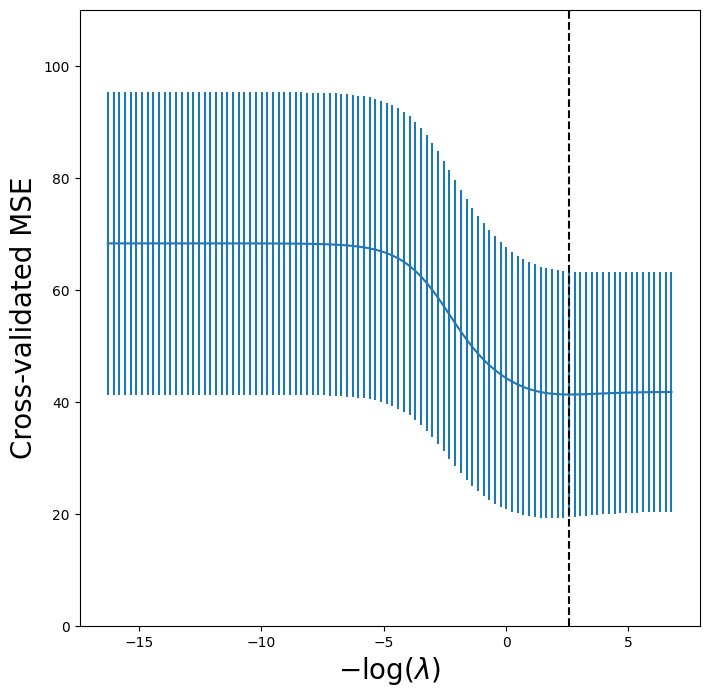

In [99]:
ridge_fig, ax = subplots(figsize=(8,8))
ax.errorbar(-np.log(lambdas),
            -grid.cv_results_['mean_test_score'],
            yerr=grid.cv_results_['std_test_score'] / np.sqrt(K))
ax.axvline(-np.log(grid.best_params_['ridge__alpha']), c='k', ls='--')
ax.set_ylim([0,110])
ax.set_xlabel('$-\log(\lambda)$', fontsize=20)
ax.set_ylabel('Cross-validated MSE', fontsize=20);

In [100]:
grid.best_params_['ridge__alpha']

0.07649012085627331

In [101]:
grid.best_estimator_.named_steps['ridge'].coef_

array([ 0.64541823, -0.62786115, -0.2308241 , -0.38675037,  0.6207614 ,
       -0.23025256, -1.31098664,  3.54261392,  0.62404065, -0.33496845,
        1.47173289, -1.40936213])

In [102]:
np.min(-grid.cv_results_['mean_test_score'])

41.287259150678466

In [103]:
CV_errors['Ridge'] = np.min(-grid.cv_results_['mean_test_score']) 

### PCR

In [105]:
pca = PCA(n_components=2)
linreg = skl.LinearRegression()

pipe = Pipeline([('scaler', scaler), 
                 ('pca', pca),
                 ('linreg', linreg)])

param_grid = {'pca__n_components': range(1, X.shape[1] + 1)}

gridCV = skm.GridSearchCV(pipe,
                        param_grid,
                        cv=kfold,
                        scoring='neg_mean_squared_error')

In [106]:
gridCV.fit(X_train, Y_train)

Y_pred = gridCV.best_estimator_.predict(X_test)
test_mse = np.mean((Y_test - Y_pred)**2)

print('Best params:', gridCV.best_params_)
print('Test MSE:', test_mse)    

Best params: {'pca__n_components': 10}
Test MSE: 54.28536961611121


In [107]:
CV_errors['PCR'] = np.min(-grid.cv_results_['mean_test_score'])

### Results

In [108]:
CV_errors

{'Best Subset': 41.481162052622985,
 'Lasso': 41.488203881238015,
 'Ridge': 41.287259150678466,
 'PCR': 41.287259150678466}

Best subset provides the best model here.

c) It does note use all the features, it used 9 of the features. All would overfit, less would underfit.